In [1]:
!git clone https://github.com/duyet/vietnamese-wordlist.git

Cloning into 'vietnamese-wordlist'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 55 (delta 0), reused 1 (delta 0), pack-reused 52 (from 1)
Receiving objects: 100% (55/55), 650.75 KiB | 12.51 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [42]:
import gc
import os
import re
import string
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = '/kaggle/input/10000-vietnamese-books/output'
data = []
name = []
for filename in os.listdir(DATA_PATH)[:50]:
    name.append(filename.split('.')[0])
    filepath = os.path.join(DATA_PATH, filename)
    f = open(filepath, 'r')
    data.append(f.read())
    f.close()

In [4]:
with open('/kaggle/working/vietnamese-wordlist/Viet74K.txt', 'r') as f:
    vocab = f.read()

In [5]:
vocab = vocab.split('\n')
vocab = [word for word in vocab if len(word.split()) == 1]
vocab = list(set(vocab))
print(len(vocab))

8956


In [6]:
vocab_dict = {word: idx for idx, word in enumerate(vocab, start=2)}
vocab_dict['<oov>'] = 1
vocab_size = len(vocab_dict)
print(vocab_size)

8957


In [7]:
def get_index(word):
    token = vocab_dict.get(word)
    if token == None:
        return 1
    return token

def text_to_sequence(data):
    sequence = []
    for text in data:
        sequence.append([get_index(word) for word in text.split()])
    return sequence

In [8]:
avg = 0
for t in data:
    avg += len(t.split())
avg = avg/len(data)
print(f'Average words per doc: {avg}')
del avg

Average words per doc: 35325.9


In [9]:
name[0]

'Nhà ảo thuật - Mạc Can'

In [10]:
for i in range(len(data)):
    temp = name[i].split(' - ')
    if len(temp) == 2:
        data[i] = data[i].replace(temp[0], '')
        data[i] = data[i].replace(temp[1], '')
del name

In [11]:
punctuation = string.punctuation + '“”'
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”'

In [12]:
def normalize(text):
    index = text.find("Mục lục")
    # Nếu tìm thấy "Mục lục", cắt bỏ từ vị trí đó
    if index != -1: text = text[:index]
    
    # remove html
    text = re.sub(r'<[^>]*>', ' ', text)
    
    # remove http
    text = re.sub(r'Nguồn:\s*http?:\/\/\S+', ' ', text)
    text = re.sub(r'http\S*', ' ', text)
    
    # lowercase
    text = text.lower()
    
    # remove punctuation
    text = re.sub(f'[{punctuation}₫—℅\d\n\t]', ' ', text)
    
    # remove –
    text = re.sub(r'–\s', ' ', text)
    
    # remove white space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [13]:
data = [normalize(text) for text in data]

In [14]:
data[0][:500]

'có một cậu bé muốn học vài trò ảo thuật nhưng không tìm đâu ra trường và thầy dạy một hôm rỗi rảnh người cha chở cậu con trai nhỏ xíu khoảng tuổi ngồi háo hức sau yên xe honda vòng quanh đường phố một lúc đang bình thường thì tự nhiên chiếc xe khục khịch ho khan dừng lại đầu hẻm như là có hẹn trước ngay chóc tiệm thuốc tây và cái tủ bán thuốc lá nhưng sau cái quầy trong tiệm và trên chiếc ghế thấp nơi tủ thuốc lá đặt nhờ ngoài hè đường không có người bán hàng nào còn lạ hơn là mọi người trong đó'

In [19]:
data = text_to_sequence(data)

In [20]:
gc.collect()

0

In [21]:
X = []
y = []
sequence_length = 50
step = 1
for encoded_text in tqdm(data):
    for i in range(0, len(encoded_text) - sequence_length, step):
        X.append(encoded_text[i: i + sequence_length])
        y.append(encoded_text[i + sequence_length])

100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


In [22]:
len(X)

1770250

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [25]:
len(X_train)

1593225

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [27]:
batch_size = 512
train_dataset = train_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

In [30]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_shape=(50,)),
    LSTM(256),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │       895,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8957)           │     2,301,949 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,563,217 (13.59 MB)

 Trainable params: 3,563,217 (13.59 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10,
                              min_lr=1e-6,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)
callbacks = [reduce_lr]

In [32]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=100,
                    callbacks=callbacks)

Epoch 1/100
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 109s 34ms/step - accuracy: 0.0411 - loss: 6.7009 - val_accuracy: 0.0891 - val_loss: 5.9004 - learning_rate: 0.0010
Epoch 2/100
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.0993 - loss: 5.8143 - val_accuracy: 0.1268 - val_loss: 5.5189 - learning_rate: 0.0010
Epoch 3/100
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.1287 - loss: 5.4872 - val_accuracy: 0.1449 - val_loss: 5.3272 - learning_rate: 0.0010
Epoch 4/100
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.1435 - loss: 5.2990 - val_accuracy: 0.1549 - val_loss: 5.2100 - learning_rate: 0.0010
Epoch 5/100
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.1531 - loss: 5.1686 - val_accuracy: 0.1615 - val_loss: 5.1299 - learning_rate: 0.0010
Epoch 6/100
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.1599 - loss: 5.0716 - val_accuracy: 0.1665 - val_loss: 5.0754 - learning_rate: 0.0010
Epoch 7/100
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms

In [35]:
import pickle

model.save('./text_generation_model.h5')

with open('./sequences_digit.pkl', 'wb') as f:
    pickle.dump(data, f)

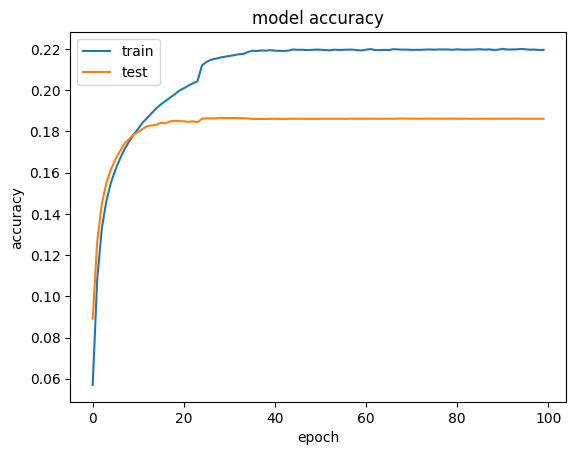

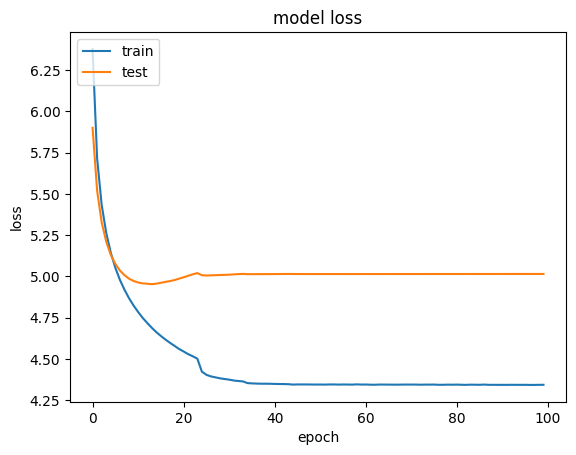

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
def preprocess_input(doc):
    doc = normalize(doc)
    tokens = text_to_sequence([doc])
    tokens = keras.preprocessing.sequence.pad_sequences(tokens, maxlen=50, truncating='pre')
    return np.reshape(tokens, (1,50))

In [56]:
def generate_text(text_input, n_words):
    tokens = preprocess_input(text_input)
    for _ in range(n_words):
        predictions = model.predict(tokens)
        next_digit = np.argmax(predictions, axis=-1)
        tokens = np.append(tokens, next_digit)
        tokens = np.delete(tokens, 0)
        tokens = np.reshape(tokens, (1, 50))
    
    # Mapping to text  
    tokens = np.reshape(tokens, (50))
    out_word = []
    for token in tokens:
        for word, index in vocab_dict.items():
            if index == token:
                out_word.append(word)
                break

    return ' '.join(out_word)

In [57]:
generate_text('đường phố ở việt nam', 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'đường phố ở <oov> nam <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov>'